In [4]:
from matplotlib import pyplot as plt
import numpy as np
import control as ct
rng = np.random.Generator(np.random.PCG64(1234))

def u(t):
    if t<0:
        raise ValueError(f'{t} is out of range')
    if t<0.5:
        return 0
    if t<1.5:
        return 0.01
    if t<2.5:
        return 0
    if t<3.5:
        return -0.01
    if t<5:
        return 0
    raise ValueError(f'{t} is out of range')

In [5]:
A = np.array([[0.672258718359780, 0.039888081099425, 0.107648580543866, 0.001863106398708],
              [-11.780113689956728, 0.512706393962079, 3.802497470071703, 0.105785474145158],
              [0.113237899739990, 0.001863106398708, 0.881966560251388, 0.046787858121196],
              [4.119853892507177, 0.105785474145158, -4.492475172248794, 0.835178702130192]])


B = 1.e4*np.array([[0.110046350548177],
                   [3.988808109942511],
                   [0.002397770004311],
                   [0.186310639870808]])

C = np.array([[1,0,0,0]]);

x1in = 50
v1in = 0
x2in = 50
v2in = 0

xk = np.array([[x1in, v1in, x2in, v2in]]).transpose()
tfin = 5
tin = 0
dt = 1/20
tar = np.arange(tin, tfin, dt)

n_states = 4    # (y1, v1, y2, v2)
n_output = 1

xkar = np.zeros((len(tar), n_states))
xkar_nf = np.zeros_like(xkar)
xkar_hat = np.zeros_like(xkar)
xkar_nf[0,:] = xk.flatten()
xkar[0,:] = xk.flatten()
# xkar_hat[0,:] = xk.flatten()

ykar = np.zeros((len(tar), n_output))
ykar_nf = np.zeros_like(ykar)

ykar_nf[0,:] = np.matmul(C, xk)

# Generate noise
l = 2 # general noise size level
H = l*np.array([[1,0,0,0,0.5],
              [0,1,0,0,0],
              [0,0,1,0,0.5],
              [0,0,0,1,0],
              [0.5,0,0.5,0,5]])


noise = np.matmul(H, rng.normal(size=(n_states+n_output, len(tar))))
wkar = noise[:n_states, :].T
vkar = noise[n_states+n_output-1,:].reshape(1,len(tar)).T


# Noise covariance matrices
Q = np.matmul(H,H.T)
W = Q[:n_states, :n_states]
S = Q[:n_states, n_states:(n_states+n_output)]
V = Q[n_states:(n_states+n_output), n_states:(n_states+n_output)]

P = ct.dare(A.T, C.T, W, V, S)[0]
L = np.matmul(np.matmul(A,np.matmul(P,C.T)) + S, np.linalg.pinv(np.matmul(np.matmul(C,P),C.T)+V))

# # Process error
# wkar = rng.normal(0,scale=2, size=xkar.shape)
# # Observation error
# vkar = rng.normal(0,scale=2, size=ykar.shape)


for k in range(len(tar)-1):
    wk = wkar[k:(k+1),:].T
    vk = vkar[k:(k+1),:].T

    xk = xkar[k:(k+1),:].T
    xk_nf = xkar_nf[k:(k+1),:].T
    tk = tar[k]

    # Noise free state
    xk_forward_nf = (np.matmul(A, xk_nf) + B*u(tar[k]))
    xkar_nf[k+1,:] = xk_forward_nf.flatten()

    # Added noise with N(0,2)
    xk_forward = (np.matmul(A, xk) + B*u(tar[k])) + wk
    xkar[k+1,:] = xk_forward.flatten()

    # Observation with added noise
    yk = np.matmul(C, xk_forward) + vk
    ykar[k+1,:] = yk

for k in range(len(tar)-1):
    xkhat = xkar_hat[k:(k+1), :].T
    yk = ykar[k:(k+1),:].T
    
    zkhat = (np.matmul(A, xkhat) + B*u(tar[k]))
    ykhat = np.matmul(C, xkhat)
    xkar_hat[k+1, :] = (zkhat + np.matmul(L, yk - ykhat)).flatten()
    # xkar_hat[k+1, :] = (xk_forward_nf + np.matmul(L, (yk - yk_nf) - np.matmul(C, xk_nf))).flatten();

### Optimal observer gain (Kalman Filter) through DARE

(-100.0, 100.0)

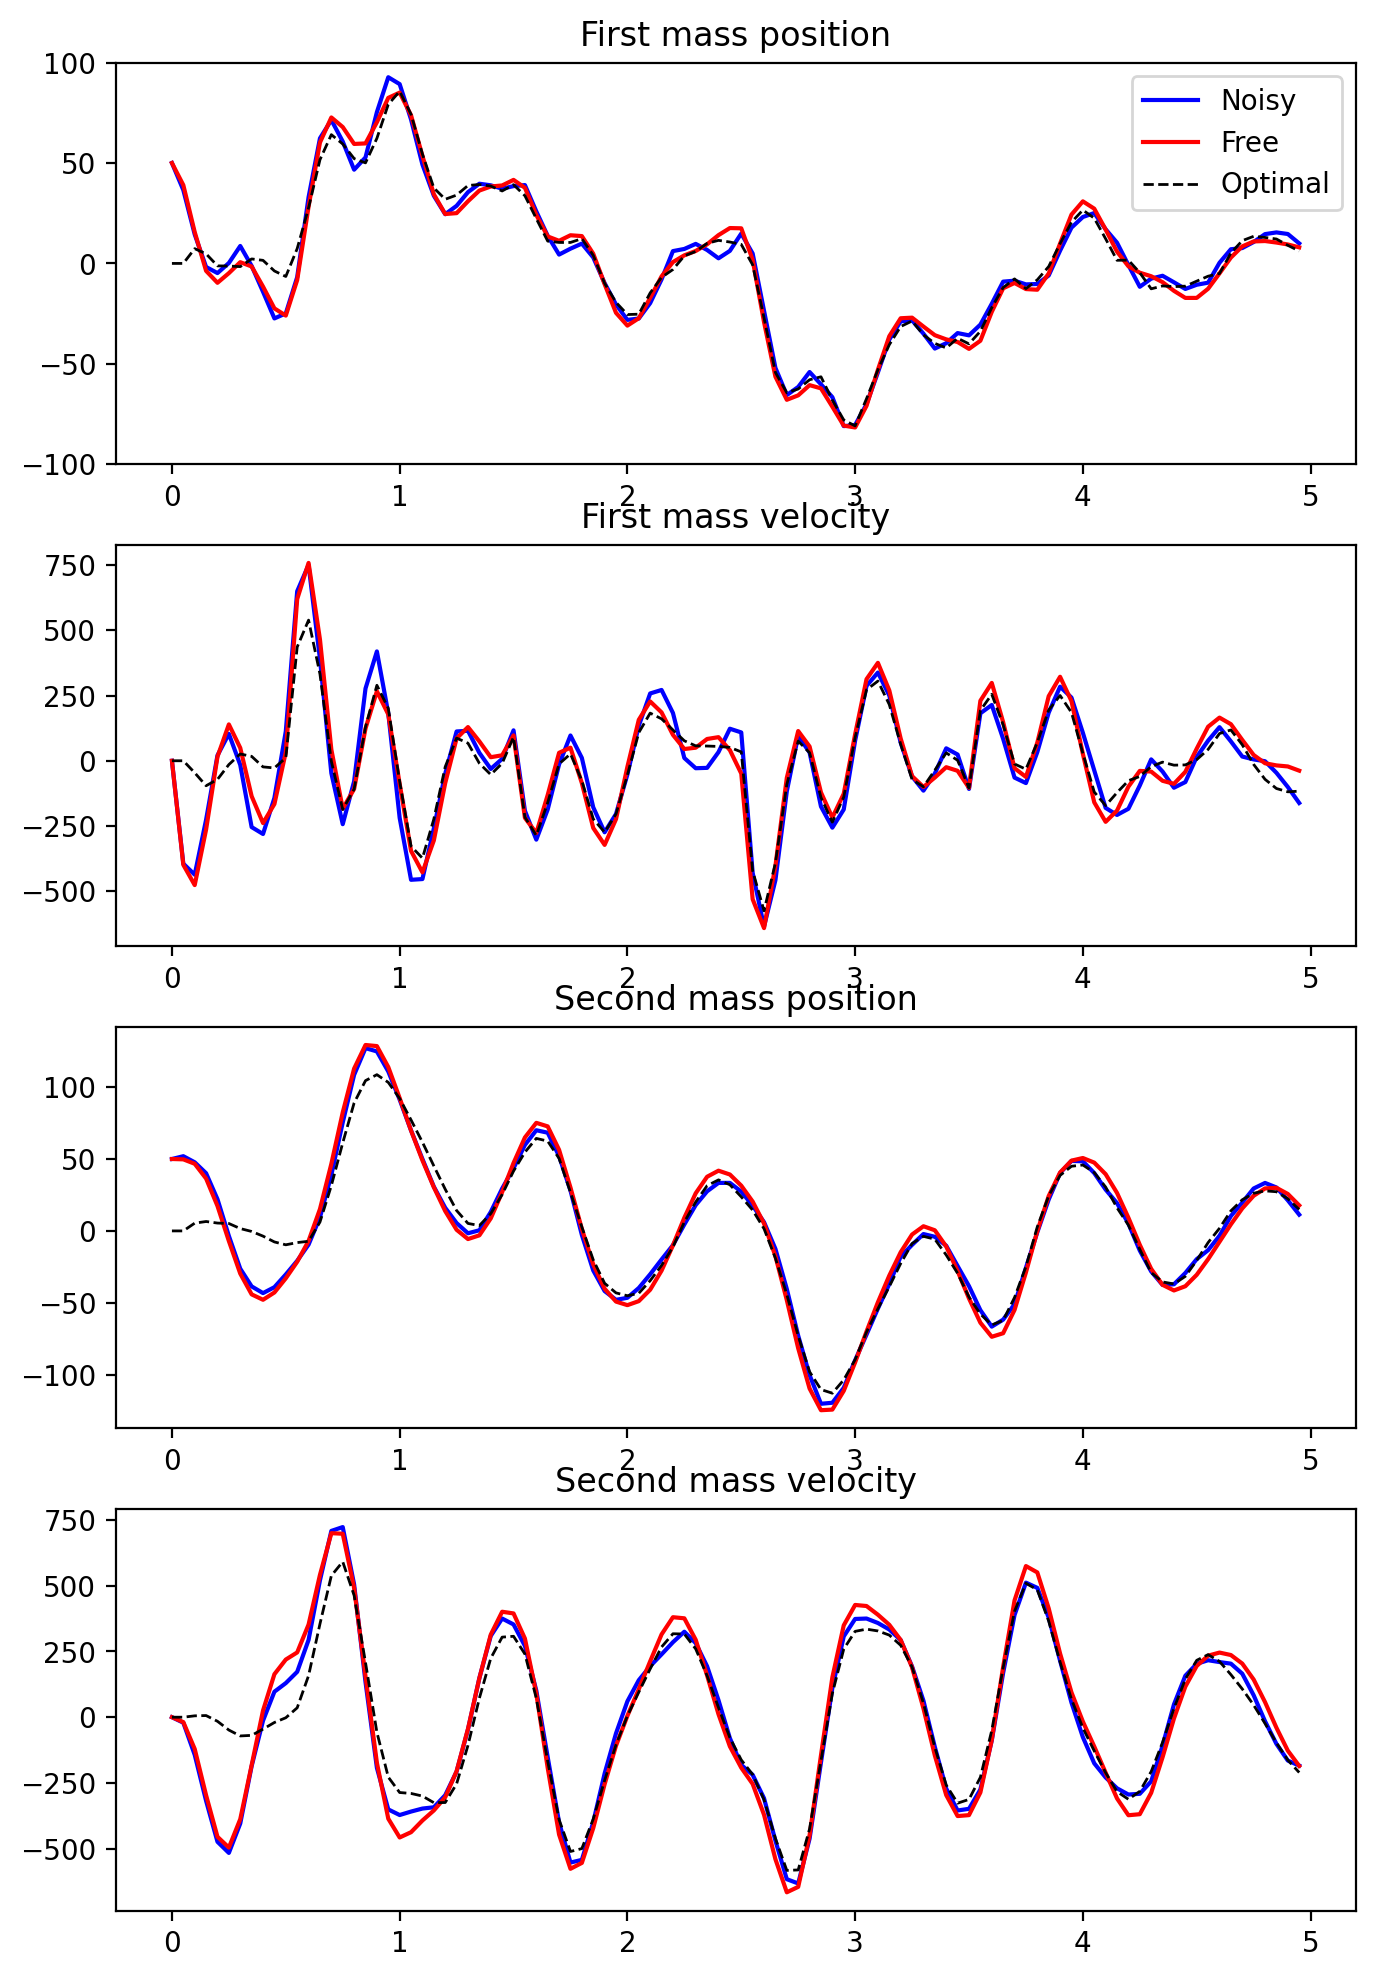

In [6]:
fig, axes2d = plt.subplots(4,1, figsize=(8,12), dpi=200, squeeze=False)

axes = axes2d.flatten()

axes[0].plot(tar, xkar[:,0], 'b-', label='Noisy')
axes[0].plot(tar, xkar_nf[:,0], 'r-', label='Free')
axes[0].plot(tar, xkar_hat[:,0], 'k--', lw=1, label='Optimal')
axes[0].set_title('First mass position')

axes[1].plot(tar, xkar[:,1], 'b-', label='Noisy')
axes[1].plot(tar, xkar_nf[:,1], 'r-', label='Free')
axes[1].plot(tar, xkar_hat[:,1], 'k--', lw=1, label='Optimal')
axes[1].set_title('First mass velocity')

axes[2].plot(tar, xkar[:,2], 'b-', label='Noisy')
axes[2].plot(tar, xkar_nf[:,2], 'r-', label='Free')
axes[2].plot(tar, xkar_hat[:,2], 'k--', lw=1, label='Optimal')
axes[2].set_title('Second mass position')

axes[3].plot(tar, xkar[:,3], 'b-', label='Noisy')
axes[3].plot(tar, xkar_nf[:,3], 'r-', label='Free')
axes[3].plot(tar, xkar_hat[:,3], 'k--', lw=1, label='Optimal')
axes[3].set_title('Second mass velocity')

axes[0].legend()

axes[0].set_ylim(-100,100)

### EnKF Design

In [9]:
# Number of ensembles
N = 100*n_states
# N = 100

# Initial state covariance matrix
X = 10*np.eye(n_states)
Xs = np.linalg.cholesky(X)

# Initial state is all zeros
xkar_hat_EnKF = np.zeros((n_states, len(tar)))

# Kalman gain
L_EnKF = np.zeros((n_states, len(tar)))

for tix in range(len(tar)-1):
    xkhat_ensemble = np.zeros((n_states, N))
    wk_ensemble = np.zeros((n_states, N))
    vk_ensemble = np.zeros((n_output, N))

    zkphat_ensemble = np.zeros((n_states, N))
    xkphat_ensemble = np.zeros((n_states, N))
    ykhat_ensemble = np.zeros((n_output, N))

    # Create N ensembles
    for j in range(N):
        # xkhat_ensembles = xkar_hat_EnKF[tix:(tix+1),:].T
        xkhat_ensemble[:,j:(j+1)] = xkar_hat_EnKF[:, tix:(tix+1)] + np.matmul(Xs, np.random.randn(n_states,1))
        
        noise_k_ensemble = np.matmul(H, np.random.randn(n_states+n_output, 1))
        wk_ensemble[:,j:(j+1)] = noise_k_ensemble[:n_states, :]
        vk_ensemble[:,j:(j+1)] = noise_k_ensemble[n_states:(n_states+n_output), :]
        
        zkphat_ensemble[:,j:(j+1)] = np.matmul(A, xkhat_ensemble[:,j:(j+1)]) + B*u(tar[tix]) + wk_ensemble[:,j:(j+1)]
        ykhat_ensemble[:,j:(j+1)] = np.matmul(C, xkhat_ensemble[:,j:(j+1)]) + vk_ensemble[:,j:(j+1)]

    zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)

    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    for n in range(n_states):
        zkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]

    for n in range(n_output):
        ykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]

    Pzy = 1/N*np.matmul(zkphat_ensemble, ykhat_ensemble.T)
    
    Py = 1/N*np.matmul(ykhat_ensemble, ykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)
    assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'

    # Compute estimated Kalman gain based on correlations
    L_EnKF[:,tix:(tix+1)] = np.matmul(Pzy, Pyinv)

    # compute mean valued state adjustmen using measurement y(k)
    xkar_hat_EnKF[:, (tix+1):(tix+2)] = zkphat_mean + np.matmul(L_EnKF[:,tix:(tix+1)], ykar[tix] - ykhat_mean)


    # Compute the state adjustment ensembles to update state covariance matrix X
    for j in range(N):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF[:,tix:(tix+1)], ykar[tix] - ykhat_ensemble[:,j:(j+1)])

    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    for n in range(n_states):
        xkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/N*np.matmul(xkphat_ensemble, xkphat_ensemble.T)
    Xs = np.linalg.cholesky(X)

(-100.0, 100.0)

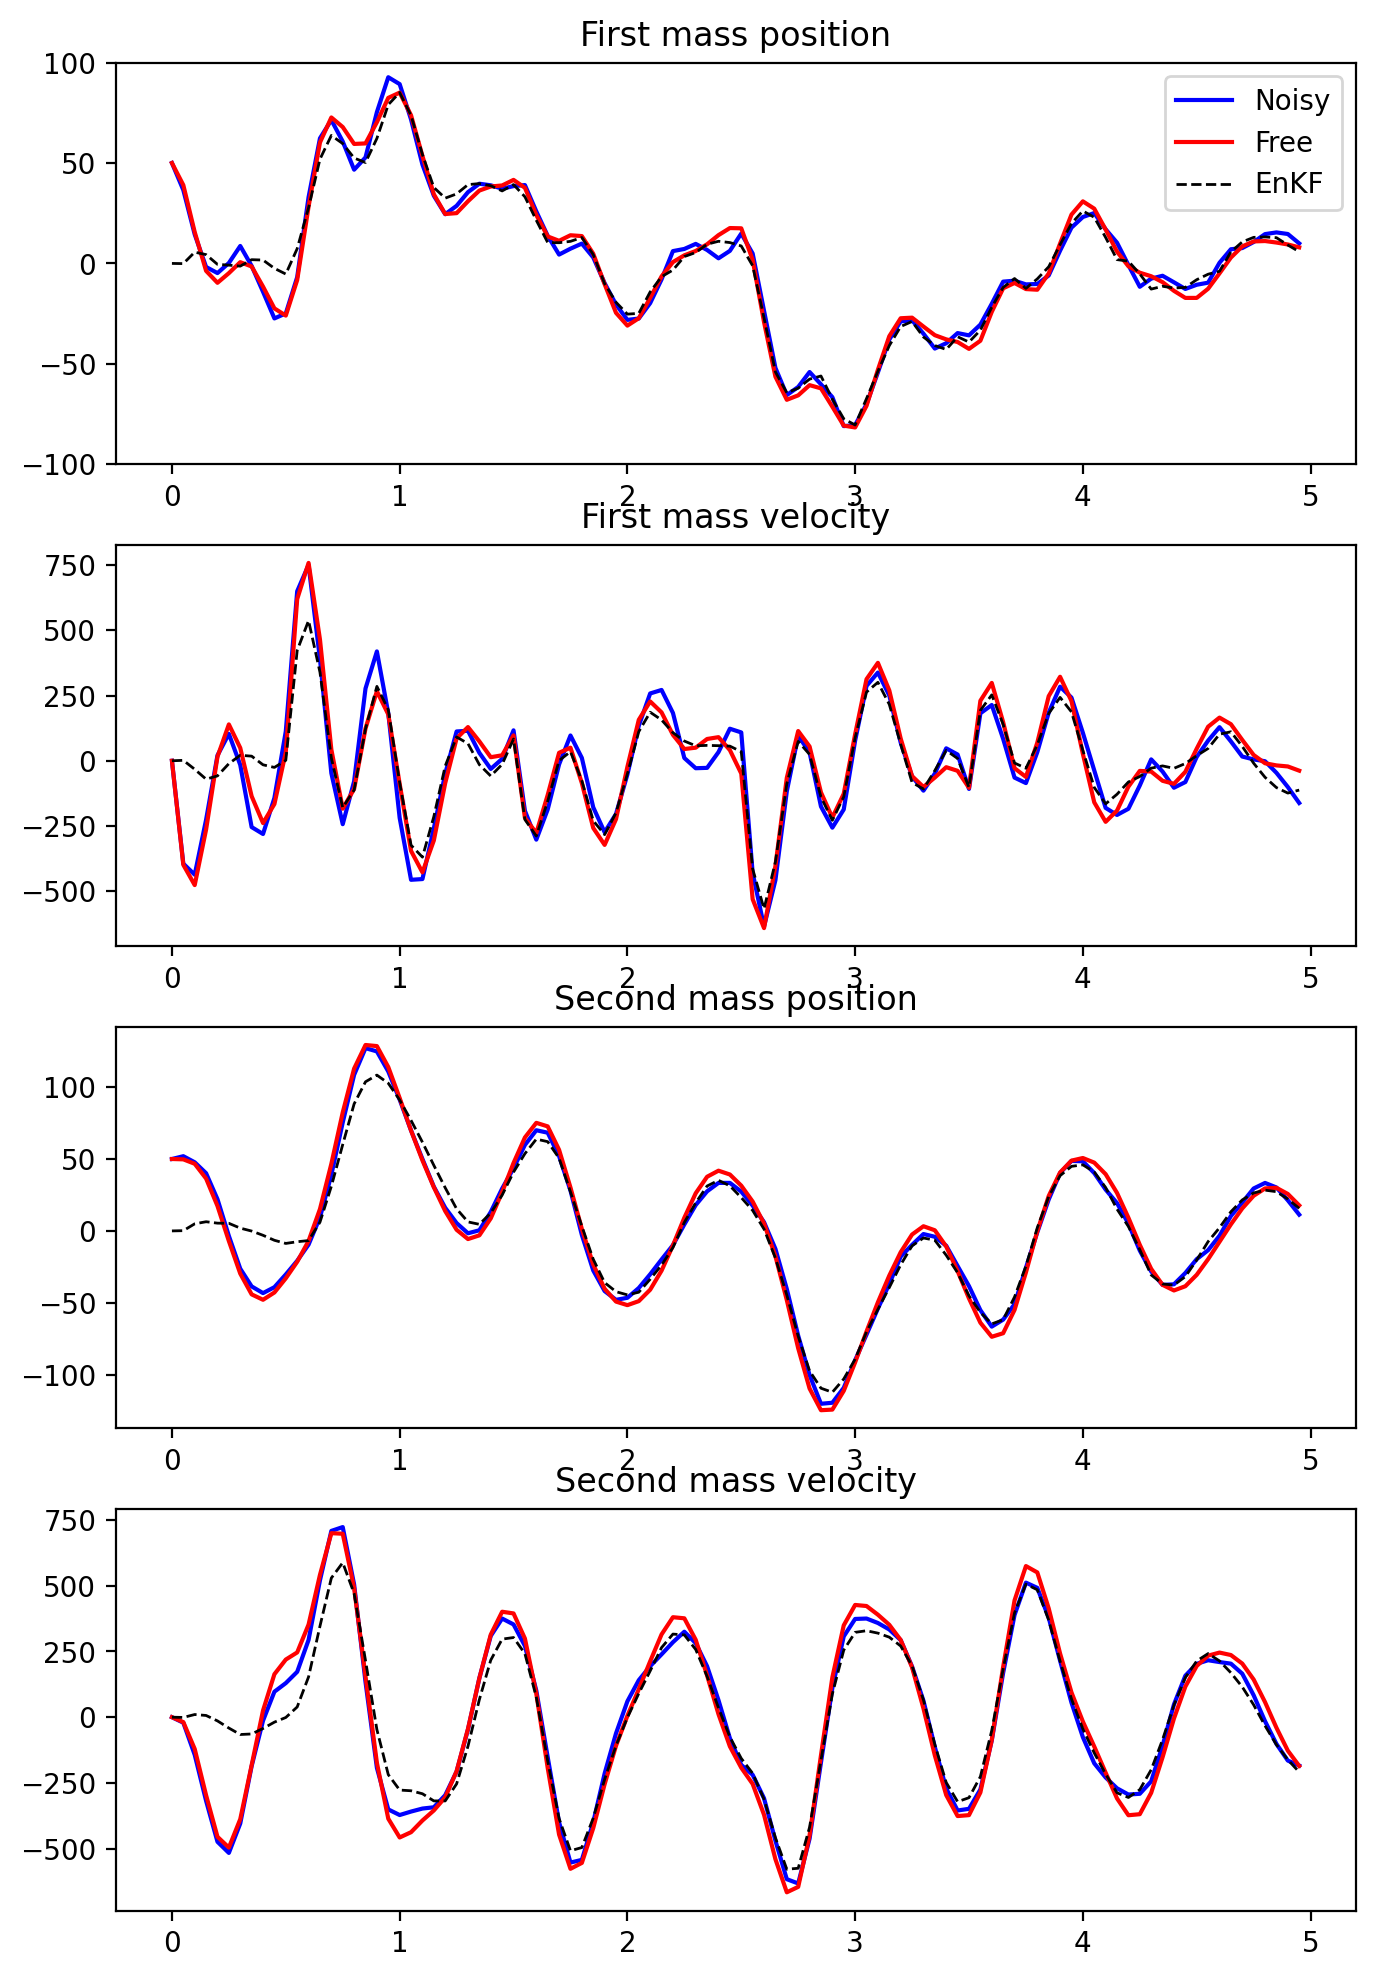

In [10]:
fig, axes2d = plt.subplots(4,1, figsize=(8,12), dpi=200, squeeze=False)

axes = axes2d.flatten()

axes[0].plot(tar, xkar[:,0], 'b-', label='Noisy')
axes[0].plot(tar, xkar_nf[:,0], 'r-', label='Free')
axes[0].plot(tar, xkar_hat_EnKF[0,:], 'k--', lw=1, label='EnKF')
axes[0].set_title('First mass position')

axes[1].plot(tar, xkar[:,1], 'b-', label='Noisy')
axes[1].plot(tar, xkar_nf[:,1], 'r-', label='Free')
axes[1].plot(tar, xkar_hat_EnKF[1,:], 'k--', lw=1, label='EnKF')
axes[1].set_title('First mass velocity')

axes[2].plot(tar, xkar[:,2], 'b-', label='Noisy')
axes[2].plot(tar, xkar_nf[:,2], 'r-', label='Free')
axes[2].plot(tar, xkar_hat_EnKF[2,:], 'k--', lw=1, label='EnKF')
axes[2].set_title('Second mass position')

axes[3].plot(tar, xkar[:,3], 'b-', label='Noisy')
axes[3].plot(tar, xkar_nf[:,3], 'r-', label='Free')
axes[3].plot(tar, xkar_hat_EnKF[3,:], 'k--', lw=1, label='EnKF')
axes[3].set_title('Second mass velocity')

axes[0].legend()

axes[0].set_ylim(-100,100)